# Introduction

"What insights can you create from this data? Can you predict map picks? Map winners? Combine those predictions and predict match winners? Give it a try!" - Machado

https://www.kaggle.com/mateusdmachado/csgo-professional-matches?select=results.csv

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
economy_df = pd.read_csv('./economy.csv')
picks_df = pd.read_csv('./picks.csv')
players_df = pd.read_csv('./players.csv')
results_df = pd.read_csv('./results.csv')

C:\Users\jared\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Summary
- First we perform exploratory analysis and visualization to have a better understanding of the data that we are working with
- Next, we construct our baseline classification model using sklearn's `DecisionTreeClassifier` which yields a **baseline accuracy of 0.563**.
- Realizing opportunity for improved model performance, we drop noisy columns and engineer new features, yielding a new accuracy of **0.583**.
- Further improving upon our model, grid search provides us with optimal hyperparameter tuning and gives us another 1% of model accuracy - improving it to **0.592**.
- As an experimental aside, model accuracy jumps to **0.670** when adding the results of the first 5 rounds as features. Although, we recognize that this is insider information that cannot be used when using this model in practice.
- Finally performing A/B testing to answer an EDA question of whether Swedish players tend to be better than United States players, we get a **p-value < 0.001**. This can be interpreted as teams of Swedish players have high mean ranking than teams of United States players.

# Understanding the Game

In this section, we will briefly view a single map between the teams Navi Vincere and G2 in order to better understand the game on an introductory level. Counter Strike: Global Offensive (CSGO) is a game in which there are two teams that fight in order to complete an objective. The "terrorist" team aims to plant a bomb at a bomb site while the "counter-terrorist" team aims to prevent these terrorists from doing so. The teams swap roles (terrorist vs. counter-terrorist) at half-time, or 15 rounds.

In [3]:
map1 = economy_df.iloc[0]

### Wins by Round

One simple visualization is a graphic that indicates which teams win at which rounds. We will also begin doing some minor rearranging to make things look nicer.

In [4]:
# getting team 1 start side (terrorist vs. counter-terrorist)
helper = lambda x: 'terrorist start' if x == 't' else 'counter-terrorist start'
t1_start = helper(map1.loc['t1_start'])

# getting DataFrame of all rounds
temp = map1.loc['1_winner':'30_winner']

# dropping null values (null values are rounds which are not played because the maps are a first to 16 basis)
temp = temp.dropna()

# converting integers to team names
mapping = {2: 'Natus Vincere', 1: 'G2'}
temp = temp.map(mapping)

# relabeling indexes to integers to represent rounds
temp = temp.rename(index={round: i+1 for (i, round) in enumerate(temp.index)})

After doing some minor rearranging we can plot a chart for the winner of each round of the map. Notice that the rounds end at 20 here because the maps conclude after one team reaches 16 winning rounds first. In this case, Natus Vincere won by round 20. Other maps may extend to 30+ rounds if overtime conditions are met.

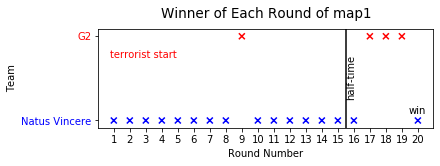

In [5]:
# creating plot
fig1 = plt.figure()
plt.subplot(2,1,1)
colors = ['r' if team == 'G2' else 'b' for team in temp.values]
plt.scatter(x=temp.index, y=temp.values, c=colors, marker='x')

# labeling and coloring
plt.title('Winner of Each Round of map1', fontsize=13.5, y=1.05)
plt.xlabel('Round Number')
plt.ylabel('Team')
plt.xticks(ticks=np.arange(1, len(temp)+1))
colors = ['b', 'r']
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), colors):
    ticklabel.set_color(tickcolor)

# adding vertical line to indicate a swapping of sides
plt.axvline(x=15.5,c='black')
plt.text(0.75,0.75,t1_start,color='red')
plt.text(15.5,0.275,'half-time',rotation=90);
plt.text(19.40,0.075,'win');

### Economy by Round

Additionally, we can visualize the game economy of the two teams. In CSGO, the winner of each round is granted greater money for spending on greater weapons, utility, and etc. towards the coming rounds. Therefore on any given round, we expect the team with the more expensive arsenal to win.

In [6]:
temp = map1.loc['1_t1':'30_t2']
temp = temp.dropna()

# splitting the economy into the respective teams: 
# temp_1 refers to team 1 (G2) 
# temp_2 refers to team 2 (Natus Vincere)
temp_1, temp_2 = temp.iloc[:len(temp)//2], temp.iloc[len(temp)//2:]
temp_1 = temp_1.rename(index={round:i+1 for i,round in enumerate(temp_1.index)})
temp_2 = temp_2.rename(index={round:i+1 for i,round in enumerate(temp_2.index)})

After the minor cleaning/rearranging, we can see that the economy of Natus Vincere is much more abundant throughout the map and this is expected based off of our previous graph; the previous graph showed how Natus Vincere won many more rounds and the game rewards winning teams with greater wealth as also shown here.

One interesting visual point here is that the game economy of G2 undulates back and forth from low economy (or "save" rounds) and large economy (or "buy" rounds). This is typically because as a team undergoes a "losing streak," their economy is highly sensitive, and therefore, they may opt for "saving" one round in order to "full buy" the successive round. However, once a team loses this "full buy" round, their economy drops back to low amounts and the vicious cycle repeats. On a somewhat related note, it is also interesting to see that on round 10, G2 does not have a low economy despite the undulating pattern. This is due to their previous round's win (round 9) where the game rewarded G2 with more money upon success.

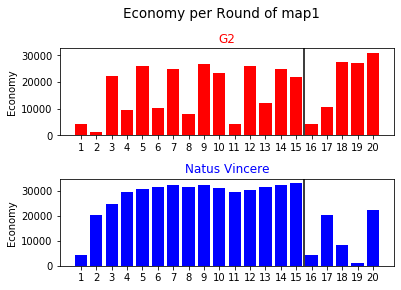

In [7]:
# creating plot
fig2, axes = plt.subplots(2)
fig2.subplots_adjust(hspace=0.5)
axes[0].bar(x=temp_1.index, height=temp_1.values, color='r')
axes[1].bar(x=temp_2.index,height=temp_2.values, color='b')

# labeling
fig2.suptitle('Economy per Round of map1', fontsize=13.5, y=1.025)
axes[0].set_title('G2', color='r')
axes[1].set_title('Natus Vincere', color='b')
axes[0].set_ylabel('Economy')
axes[1].set_ylabel('Economy')
axes[0].set_xticks(ticks=np.arange(1, len(temp_1)+1));
axes[1].set_xticks(ticks=np.arange(1, len(temp_2)+1));

# adding vertical line to indicate a swapping of sides
axes[0].axvline(x=15.5, color='black');
axes[1].axvline(x=15.5, color='black');

# EDA
Here, we begin to wonder: *What teams win the most?* *Where do these teams come from?* *What are the current leaderboards?* This section will seek to answer some of these general questions which will help guide us in the right direction toward model training.

In [8]:
def pivot_results(df, year=None, single=False):

    temp = df[['date', 'team_1', 'team_2', 'map_winner', 'rank_1', 'rank_2']].applymap(lambda x: str.lower(x) if type(x) == str else x)
    temp['date'] = pd.to_datetime(temp['date']).apply(lambda x: x.year)
    
    if year:
        if single:
            temp = temp[temp['date'] == year]
        else:
            temp = temp[temp['date'] >= year]

    index_1 = temp['team_1'].unique()
    index_2 = temp['team_2'].unique()
    index = set(np.append(index_1, index_2))

    count = []
    wins = []
    win_rate = []
    mean_rank = []

    for team in index:
        rows_1 = temp.loc[temp['team_1'] == team]
        rows_2 = temp.loc[temp['team_2'] == team]

        total = (
            len(rows_1) + 
            len(rows_2)
        )
        x = (
            len(rows_1[rows_1['map_winner'] == 1]) +
            len(rows_2[rows_2['map_winner'] == 2])
        )
        rank_total = (
            sum(rows_1['rank_1']) + 
            sum(rows_2['rank_2'])
        )
        count.append(total)
        wins.append(x)
        win_rate.append(x/total)
        mean_rank.append(rank_total/total)

    output = pd.DataFrame(data={'count': count, 'wins': wins, 'win_rate': win_rate, 'mean_rank': mean_rank}, index=index)
    
    return output

In [9]:
pivot_df = pivot_results(results_df)

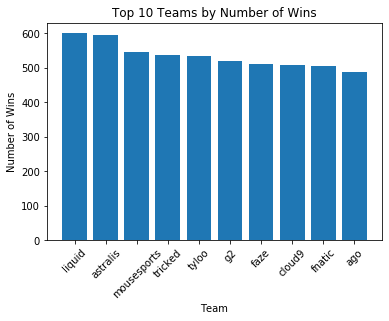

In [10]:
temp = pivot_df['wins'].sort_values(ascending=False)

plt.bar(x=temp[:10].index, height=temp[:10]);
plt.title('Top 10 Teams by Number of Wins');
plt.xlabel('Team');
plt.ylabel('Number of Wins');
plt.xticks(rotation=45);

Plotting the top 10 teams by total number of wins, **Liquid** has the most number of wins.

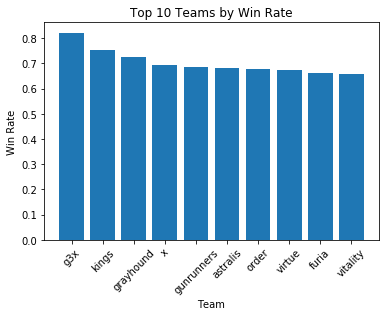

In [11]:
temp = pivot_df[pivot_df['count'] >= 30]['win_rate'].sort_values(ascending=False)

plt.bar(x=temp.index[:10], height=temp[:10])
plt.title('Top 10 Teams by Win Rate');
plt.xlabel('Team');
plt.ylabel('Win Rate');
plt.xticks(rotation=45);

Plotting the top 10 teams by win rate, excluding teams with small match history (using an arbitrary threshold of n >= 30), **G3X** has the highest win rate.

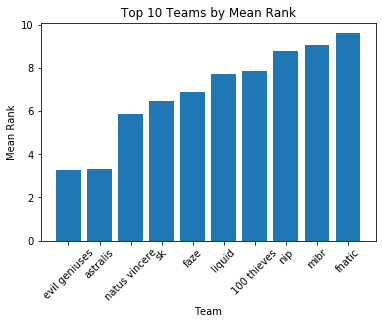

In [12]:
temp = pivot_df[pivot_df['count'] >= 30]['mean_rank'].sort_values()

plt.bar(x=temp.index[:10], height=temp[:10]);
plt.title('Top 10 Teams by Mean Rank');
plt.xlabel('Team');
plt.ylabel('Mean Rank');
plt.xticks(rotation=45);

Plotting the top 10 teams by mean rank (the lower the better). **Evil Geniuses** has the best mean rank with Astralis at a very close second.

C:\Users\jared\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


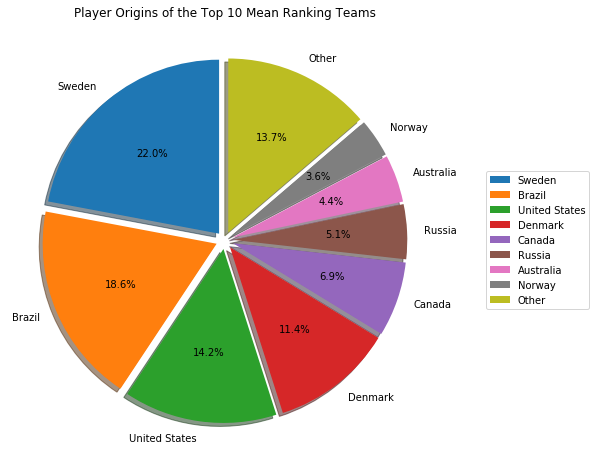

In [13]:
top_10 = pivot_df[pivot_df['count'] >= 30]['mean_rank'].sort_values()[:10].index
index = players_df['player_id'].unique()
temp = players_df.iloc[index]
temp.loc[:, 'team'] = temp.loc[:, 'team'].str.lower()
is_top_10 = temp['team'].apply(lambda x: True if x in top_10 else False)
temp = temp.assign(**{'is_top_10': is_top_10})
temp = temp[temp['is_top_10'] == True]
temp = temp['country'].value_counts()
temp = temp[:8].append(pd.Series({'Other': sum(temp[8:])}))

fig = plt.gcf()
fig.set_size_inches(8,8)

plt.pie(x=temp, labels=temp.index, explode=np.repeat(np.array([0.05]),9), autopct='%1.1f%%', startangle=90, shadow=True);
plt.title('Player Origins of the Top 10 Mean Ranking Teams')
plt.legend(loc='right', bbox_to_anchor=(1.35,0.5));

Plotting the player origins of the top 10 teams in mean rank. **Sweden** is the single most likely country that players from the top 10 teams come from.


# Building a Baseline Classification Model
With such a large and complex dataset, we can simplify things and build a baseline model with a small, comfortable set of features instead

### Cleaning the Dataset

Here, we will only merge the two dataframes of `economy_df` and `results_df`. However since they each contain several features that we may not want, we will drop many of the columns in preparation to training.

In [14]:
def clean_economy(df):
    # dropping unneeded columns
    temp = df.drop(economy_df.loc[:, '1_t1':'30_winner'], axis=1)
    temp = temp.drop(['date', 'event_id'], axis=1)
    # converting strings to lower
    temp['team_1'] = temp['team_1'].apply(str.lower)
    temp['team_2'] = temp['team_2'].apply(str.lower)
    temp['_map'] = temp['_map'].apply(str.lower)
    # dropping 'best_of' entries with unusual value of 'o'
    temp = temp[temp['best_of'] != 'o']
    # converting 'best_of' to int
    temp['best_of'] = temp['best_of'].astype(int)
    return temp
    
temp_economy = clean_economy(economy_df)

In [15]:
def clean_results(df):
    # dropping unneeded columns
    temp = results_df.drop(['date', 'result_1', 'result_2', 'starting_ct', 'ct_1', 't_2', 't_1', 'ct_2', 'event_id', 'map_wins_1', 'map_wins_2', 'match_winner'], axis=1)
    # converting strings to lower
    temp['team_1'] = temp['team_1'].apply(str.lower)
    temp['team_2'] = temp['team_2'].apply(str.lower)
    temp['_map'] = temp['_map'].apply(str.lower)
    return temp

temp_results = clean_results(results_df)

This is the new merged dataset.

In [16]:
# merging the two clean dataframes
merged_df = temp_results.merge(temp_economy, on=['match_id', '_map', 'team_1', 'team_2']) #.drop('match_id', axis=1)
# creating 'temp_1' for when 'Natus Vincere' is team 1 and 'temp_2' for when Natus Vincere is team 2
temp_1, temp_2 = merged_df[merged_df['team_1'] == 'natus vincere'], merged_df[merged_df['team_2'] == 'natus vincere']

# renaming columns of temp_1 prior to concatenating
temp_1 = temp_1.drop('team_1', axis=1).rename(
    columns={'team_2': 'opp_team', 'map_winner': 'won', 'rank_1': 'rank', 'rank_2': 'opp_rank', 't1_start': 't_start', 't2_start': 'ct_start'}
)
# converting 'won', 't_start', and 'ct_start' to binary values
temp_1.loc[:, 'won'] = temp_1.loc[:, 'won'].apply(lambda x: 1 if x == 1 else 0)
temp_1.loc[:, 't_start'] = temp_1.loc[:, 't_start'].apply(lambda x: 1 if x == 't' else 0)
temp_1.loc[:, 'ct_start'] = temp_1.loc[:, 't_start'].apply(lambda x: 1 if x == 0 else 0)

# renaming columns of temp_2 prior to merging
temp_2 = temp_2.drop('team_2', axis=1).rename(
    columns={'team_1': 'opp_team', 'map_winner': 'won', 'rank_2': 'rank', 'rank_1': 'opp_rank', 't1_start': 't_start', 't2_start': 'ct_start'}
)
# converting 'won', 't_start', and 'ct_start' to binary values
temp_2.loc[:, 'won'] = temp_2.loc[:, 'won'].apply(lambda x: 1 if x == 2 else 0)
temp_2.loc[:, 't_start'] = temp_2.loc[:, 'ct_start'].apply(lambda x: 1 if x == 't' else 0)
temp_2.loc[:, 'ct_start'] = temp_2.loc[:, 't_start'].apply(lambda x: 1 if x == 0 else 0)

# concatenating 'temp_1' and 'temp_2' now that column names and values match
df = pd.concat([temp_1, temp_2], sort=False)
df

,opp_team,_map,won,match_id,rank,opp_rank,best_of,t_start,ct_start
20,astralis,nuke,1,2339401,6,1,3,0,1
21,astralis,dust2,1,2339401,6,1,3,1,0
34,liquid,dust2,1,2339399,6,3,3,1,0
37,liquid,mirage,1,2339399,6,3,3,0,1
56,faze,inferno,1,2339397,6,9,3,0,1
...,...,...,...,...,...,...,...,...,...
31313,north,mirage,0,2311225,6,5,1,1,0
31317,mousesports,cobblestone,0,2311222,6,15,1,0,1
31320,nrg,cobblestone,1,2311235,6,31,1,1,0
31335,liquid,train,1,2311220,6,19,1,1,0


### Fitting the Baseline Model

Here, we will fit the cleaned dataset into `sklearn`'s `DecisionTreeClassifier`. Since this is simply baseline model for speculation, we do not expect it to have particularly high accuracy.

In [17]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# separating data into feature vectors and target vectors
X = df.drop('won', axis=1)
y = df['won']

# preprocessing data
onehot = OneHotEncoder()
X_onehot = onehot.fit_transform(X)

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, random_state=2)

print('Training size (%): ', X_train.shape[0] / len(X))
print('Testing size (%): ', X_test.shape[0] / len(X))

Training size (%):  0.7996108949416343
Testing size (%):  0.20038910505836577


#### DecisionTreeClassifier

In [18]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('DecisionTreeClassifier accuracy: ', accuracy)

DecisionTreeClassifier accuracy:  0.5631067961165048


Our baseline model has an accuracy of **0.563**.

# Building a Better Model

In order to increase our prediction accuracy, there are a few things we can aim to accomplish:
- Remove noisy features or merge new data
- Engineer new features
- Fine-tune model parameters

### Removing Noisy Features

Using our intuition, we can surmise that the columns `best_of`, `t_start`, and `ct_start` may introduce too much noise into our model, and therefore, it may be better to omit these. However, we may even consider principal component analysis (PCA) to have a more objective decision on feature reduction. 

In [19]:
df = df.drop(['best_of', 't_start', 'ct_start'], axis=1)
df

,opp_team,_map,won,match_id,rank,opp_rank
20,astralis,nuke,1,2339401,6,1
21,astralis,dust2,1,2339401,6,1
34,liquid,dust2,1,2339399,6,3
37,liquid,mirage,1,2339399,6,3
56,faze,inferno,1,2339397,6,9
...,...,...,...,...,...,...
31313,north,mirage,0,2311225,6,5
31317,mousesports,cobblestone,0,2311222,6,15
31320,nrg,cobblestone,1,2311235,6,31
31335,liquid,train,1,2311220,6,19


### Engineering New Features

In a competitve game like CSGO, it seems like certain players/teams perform better on certain maps whether that be one side having more practice, more expertise, more advanced strategies, and etc. Because of this, engineering a feature that accounts for a team's preference, or pick (`picked`, `opp_picked`), may help better explain our data.

In [20]:
# extracting columns from `picks_df` for merging
temp_1 = picks_df.loc[picks_df['team_1'] == 'Natus Vincere', ['team_1', 'team_2', 'match_id', 't1_removed_1', 't1_removed_2', 't1_removed_3', 't2_removed_1', 't2_removed_2', 't2_removed_3', 't1_picked_1', 't2_picked_1']]
temp_1 = temp_1.applymap(lambda x: x.lower() if type(x) == str else x)
temp_2 = picks_df.loc[picks_df['team_2'] == 'Natus Vincere', ['team_1', 'team_2', 'match_id', 't1_removed_1', 't1_removed_2', 't1_removed_3', 't2_removed_1', 't2_removed_2', 't2_removed_3', 't1_picked_1', 't2_picked_1']]
temp_2 = temp_2.applymap(lambda x: x.lower() if type(x) == str else x)

removed = {}
opp_removed = {}
picked = {}
opp_picked = {}

# looping through match id's for when Natus Vincere is team 1
for index in temp_1['match_id']:
    row = temp_1[temp_1['match_id'] == index]
    
    # Natus Vincere map picks
    try:
        picked[index].append(row['t1_picked_1'].iloc[0])
    except:
        picked[index] = [row['t1_picked_1'].iloc[0]]
        
    # opponent map picks
    try:
        opp_picked[index].append(row['t2_picked_1'].iloc[0])
    except:
        opp_picked[index] = [row['t2_picked_1'].iloc[0]]
    
# looping through unique match id's for when Natus Vincere is team 2
for index in temp_2['match_id']:
    row = temp_2[temp_2['match_id'] == index]
    
    # opponent map picks
    try:
        opp_picked[index].append(row['t1_picked_1'].iloc[0])
    except:
        opp_picked[index] = [row['t1_picked_1'].iloc[0]]
       
    # Natus Vincere map picks
    try:
        picked[index].append(row['t2_picked_1'].iloc[0])
    except:
        picked[index] = [row['t2_picked_1'].iloc[0]]

In [21]:
def picked_helper(row):
    try:
        if row['_map'] in picked[row['match_id']]:
            return 1
        else:
            return 0
    except:
        return 0

def opp_picked_helper(row):
    try:
        if row['_map'] in opp_picked[row['match_id']]:
            return 1
        else:
            return 0
    except:
        return 0

df = df.assign(**{'picked': df.apply(picked_helper, axis=1), 'opp_picked': df.apply(opp_picked_helper, axis=1)})
df

,opp_team,_map,won,match_id,rank,opp_rank,picked,opp_picked
20,astralis,nuke,1,2339401,6,1,0,1
21,astralis,dust2,1,2339401,6,1,1,0
34,liquid,dust2,1,2339399,6,3,1,0
37,liquid,mirage,1,2339399,6,3,0,1
56,faze,inferno,1,2339397,6,9,0,0
...,...,...,...,...,...,...,...,...
31313,north,mirage,0,2311225,6,5,0,0
31317,mousesports,cobblestone,0,2311222,6,15,0,0
31320,nrg,cobblestone,1,2311235,6,31,0,0
31335,liquid,train,1,2311220,6,19,0,0


In [22]:
X = df.drop('won', axis=1)
y = df['won']

# preprocessing data
onehot = OneHotEncoder()
X_onehot = onehot.fit_transform(X)

# splitting data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, random_state=2)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('DecisionTreeClassifier accuracy: ', accuracy)

DecisionTreeClassifier accuracy:  0.5825242718446602


After dropping noisy features and engineering, we get a new model accuracy of **0.583**.

### Fine Tuning Model Parameters

In [23]:
from sklearn.model_selection import GridSearchCV

After running grid search with the parameter array below on the DecisionTreeClassifier, we seem to get the best accuracy scores using `criterion = 'entropy'`, `max_depth = 2`, `min_samples_leaf = 2`, and `min_samples_split = 2`.

In [24]:
parameters = [{'criterion': ['gini','entropy'],
               'max_depth': [None,2,4,8,16,32], 
               'min_samples_split': [2,4,8,16,32], 
               'min_samples_leaf': [2,4,8,16,32]}]

# preprocessing data
onehot = OneHotEncoder()
X_onehot = onehot.fit_transform(X)

# splitting data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, random_state=2)

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid_search=grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

0.5936739659367397
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 32}


C:\Users\jared\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Running grid search informs that the ideal model parameters for `criterion`, `max_depth`, `min_samples_leaf`, and `min_samples_split` are `gini`, 2, 4, and 32, respectively.

In [25]:
X = df.drop('won', axis=1).drop('_map', axis=1)
y = df['won']

# preprocessing data
onehot = OneHotEncoder()
X_onehot = onehot.fit_transform(X)

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, random_state=2)

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=4, min_samples_split=32)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
    
print('DecisionTreeClassifier accuracy: ', accuracy)

DecisionTreeClassifier accuracy:  0.5922330097087378


Our hyperparameter-tuned model has a new accurcay of **0.592**.

As a fun aside, we can observe how our model adjusts to insider information of maps such as the results of the first 5 rounds. Our intuition is that if the model can observe the results of the first 5 rounds, then it may perform better in predicting the final winner of the map.

In [26]:
def df_n_rounds(df, n):
    
    n_rounds = n

    columns = ['match_id', 'team_1', 'team_2', '_map']
    # appending 'n_rounds' rounds
    for i in range(n_rounds):
        columns.append(str(i+1) + '_winner')

    # creating 'temp_1' for when 'Natus Vincere' is team 1 and 'temp_2' for when Natus Vincere is team 2
    # converting strings to lower
    temp_1 = economy_df.loc[economy_df['team_1'] == 'Natus Vincere', columns]
    temp_1 = temp_1.applymap(lambda x: x.lower() if type(x) == str else x)
    temp_2 = economy_df.loc[economy_df['team_2'] == 'Natus Vincere', columns]
    temp_2 = temp_2.applymap(lambda x: x.lower() if type(x) == str else x)

    # renaming columns prior to concatenating
    temp_1 = temp_1.drop('team_1', axis=1).rename(columns={'team_2': 'opp_team'})
    temp_2 = temp_2.drop('team_2', axis=1).rename(columns={'team_1': 'opp_team'})

    # converting the values of each round winner to binary
    for i in range(n_rounds):
        temp_1[str(i+1) + '_winner'] = temp_1[str(i+1) + '_winner'].apply(lambda x: 1 if x == 1 else 0)
        temp_2[str(i+1) + '_winner'] = temp_2[str(i+1) + '_winner'].apply(lambda x: 1 if x == 2 else 0)

    output = pd.concat([temp_1, temp_2], sort=False)
    output = df.merge(output, on=['opp_team', 'match_id', '_map'])
    return output

df_5_rounds = df_n_rounds(df, 5)
df_5_rounds

,opp_team,_map,won,match_id,rank,opp_rank,picked,opp_picked,1_winner,2_winner,3_winner,4_winner,5_winner
0,astralis,nuke,1,2339401,6,1,0,1,0,1,1,1,1
1,astralis,dust2,1,2339401,6,1,1,0,1,1,1,0,1
2,liquid,dust2,1,2339399,6,3,1,0,1,0,0,0,1
3,liquid,mirage,1,2339399,6,3,0,1,1,0,0,0,1
4,faze,inferno,1,2339397,6,9,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,north,mirage,0,2311225,6,5,0,0,0,0,0,0,1
510,mousesports,cobblestone,0,2311222,6,15,0,0,0,0,1,0,0
511,nrg,cobblestone,1,2311235,6,31,0,0,1,1,1,1,1
512,liquid,train,1,2311220,6,19,0,0,0,0,1,1,1


In [27]:
X = df_5_rounds.drop('won', axis=1).drop('_map', axis=1)
y = df_5_rounds['won']

# preprocessing data
onehot = OneHotEncoder()
X_onehot = onehot.fit_transform(X)

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, random_state=2)

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=4, min_samples_split=32)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

print('DecisionTreeClassifier accuracy: ', accuracy)

DecisionTreeClassifier accuracy:  0.6699029126213593


With this experimental model, we get an accuracy of **0.670**.

# A/B Testing

Tying loose ends with our EDA from earlier, we may be curious as to why so many players of the top 10 mean ranking teams have players of Swedish origin. Here, we will conduct an A/B test to determine whether the teams of Swedish players have higher mean rank than the teams of United States players at a significant degree. We will use a significance level of alpha = 0.05.

- Null hypothesis: The teams of Swedish players have equal mean rank as the teams of United States players.
- Alternative hypothesis: The teams of Swedish players have higher mean rank than the teams of United States players

In [28]:
results_df

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2
1,2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2
2,2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2
3,2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2
4,2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45768,2015-11-05,G2,E-frag.net,Inferno,13,16,2,1,8,7,5,9,1970,2299059,7,16,1,2,2
45769,2015-11-05,G2,E-frag.net,Dust2,16,13,1,1,10,5,6,8,1970,2299059,7,16,1,2,2
45770,2015-11-04,CLG,Liquid,Inferno,16,12,1,1,7,8,9,4,1934,2299011,10,14,16,12,1
45771,2015-11-03,NiP,Dignitas,Train,16,4,1,2,4,1,12,3,1934,2299001,6,12,16,4,1


In [29]:
temp = players_df[['date', 'player_name', 'country']]
temp = temp[(temp['country'] == 'United States') | (temp['country'] == 'Sweden')]

In [30]:
indexes = []
for player in temp['player_name'].unique():
    indexes.append(temp[temp['player_name'] == player].sort_values(by='date', ascending=False).index[0])

In [31]:
players = players_df.iloc[indexes][['player_name', 'team', 'country']]
players['team'] = players['team'].str.lower()
pivot_df = pivot_df.assign(**{'team': pivot_df.index})

In [32]:
merged_df = players.merge(pivot_df, on='team', how='left').dropna()[['country', 'mean_rank']]

In [33]:
us = merged_df[merged_df['country'] == 'United States']
s = merged_df[merged_df['country'] == 'Sweden']

In [34]:
us_mean = us['mean_rank'].mean()
s_mean = s['mean_rank'].mean()

us_var = us['mean_rank'].var()
s_var = s['mean_rank'].var()

us_count = len(us)
s_count = len(s)

table = pd.DataFrame({'mean': [us_mean, s_mean], 'var': [us_var, s_var], 'count': [us_count, s_count]}, index=['United States', 'Sweden'])

In [35]:
table

,mean,var,count
United States,146.324496,4943.368106,630
Sweden,109.531034,3344.937534,259


In [36]:
from scipy.stats import norm

diff = table['mean'][0] - table['mean'][1]
z_score = diff / (np.sqrt(us_var/us_count+s_var/s_count))
p_value = norm.pdf(z_score)

pd.Series([diff, z_score, p_value], index=['diff', 'z_score', 'p_value'])

diff       3.679346e+01
z_score    8.074990e+00
p_value    2.765181e-15
dtype: float64

With a p-value of **2.765e-15** < 0.05, we reject our null hypothesis. We found statistically significant evidence that the teams of Swedish players have higher mean rankings than the teams of United States players.